<a href="https://colab.research.google.com/github/azizamirsaidova/graphanalytics/blob/main/SparkGraphXDemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Graph Analytics Demo**
**Using Spark GraphX**



---


# **Spark and GraphFrames Set Up**


In [ ]:
# install java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.2.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.0-bin-hadoop3.2"

# install findspark using pip
!pip install -q findspark

# install pyspark
!pip3 install pyspark==3.2.0

# install graphframes
!pip3 install graphframes

     |████████████████████████████████| 281.3 MB 35 kB/s 
     |████████████████████████████████| 198 kB 51.3 MB/s 


Download the graphframes jar file from: [Graphframe jar file:](https://repos.spark-packages.org/graphframes/graphframes/0.8.2-spark3.2-s_2.12/graphframes-0.8.2-spark3.2-s_2.12.jar)

Upload it in the Google Colab Files folder. Can be found in the left pane of this window.

In [ ]:
!cp -v /content/graphframes-0.8.2-spark3.2-s_2.12.jar $SPARK_HOME/jars/

'/content/graphframes-0.8.2-spark3.2-s_2.12.jar' -> '/content/spark-3.2.0-bin-hadoop3.2/jars/graphframes-0.8.2-spark3.2-s_2.12.jar'


In [ ]:
#import the packages
from pyspark import *
from pyspark.sql import *
from graphframes import *
import findspark
import pandas as pd

findspark.init()

# Start a Spark session
spark = SparkSession.builder.master("local[*]").getOrCreate()



---
# **This notebook covers the following:**


---


1.  **GraphFrames Basic Attributes**


*   vertices
*   edges
*   inDegrees
*   outDegrees
*   degrees

2.  **Built-In Algorithms**

*   Connected Components
*   PageRank
*   Triangle Count
*   Label Propagation

3. **CPDB Example**

* Connect to the CPDB database
* Create a graph from SQL tables
* Graph Analytics 


# **GraphX Basic Attributes**

In [ ]:
vertices = spark.createDataFrame([
  ("a", "Alice", 34),
  ("b", "Bob", 36),
  ("c", "Charlie", 30),
  ("d", "David", 29),
  ("e", "Esther", 32),
  ("f", "Fanny", 36),
  ("g", "Gabby", 60)], ["id", "name", "age"])

In [ ]:
edges = spark.createDataFrame([
  ("a", "b", "friend"),
  ("b", "c", "follow"),
  ("c", "b", "follow"),
  ("f", "c", "follow"),
  ("e", "f", "follow"),
  ("e", "d", "friend"),
  ("d", "a", "friend"),
  ("a", "e", "friend")
], ["src", "dst", "relationship"])

In [ ]:
g = GraphFrame(vertices, edges)

In [ ]:
g.vertices.show()

+---+-------+---+
| id|   name|age|
+---+-------+---+
|  a|  Alice| 34|
|  b|    Bob| 36|
|  c|Charlie| 30|
|  d|  David| 29|
|  e| Esther| 32|
|  f|  Fanny| 36|
|  g|  Gabby| 60|
+---+-------+---+



In [ ]:
g.edges.show()

+---+---+------------+
|src|dst|relationship|
+---+---+------------+
|  a|  b|      friend|
|  b|  c|      follow|
|  c|  b|      follow|
|  f|  c|      follow|
|  e|  f|      follow|
|  e|  d|      friend|
|  d|  a|      friend|
|  a|  e|      friend|
+---+---+------------+



In [ ]:
g.vertices.count()

7

In [ ]:
g.edges.count()

8

In [ ]:
# NetworkX to visualize the graph
import networkx as nx

def plot_graph(gx):
    g = nx.DiGraph(directed = True)
    
    g = nx.from_pandas_edgelist(gx.edges.toPandas(),'src','dst')
    g.add_nodes_from(gx.vertices.toPandas()['id'])

    nx.draw(g, with_labels=True, arrows = True, node_color='grey')

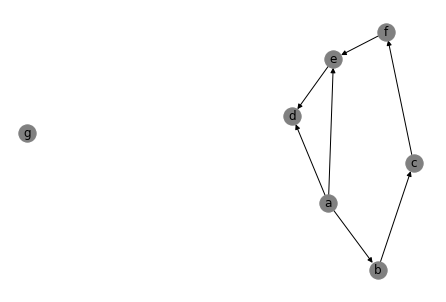

In [ ]:
plot_graph(g)

**inDegrees** is the number of edges directed into a vertex in a directed graph

Usecase: We can identify those vertices/nodes that are highly connected by using the sort function

In [ ]:
g.inDegrees.sort(['inDegree'],ascending=[0]).show()

+---+--------+
| id|inDegree|
+---+--------+
|  b|       2|
|  c|       2|
|  f|       1|
|  e|       1|
|  a|       1|
|  d|       1|
+---+--------+



**outDegrees** is the number of edges directed out of a vertex in a directed graph

In [ ]:
g.outDegrees.sort(['outDegree'],ascending=[0]).show()

+---+---------+
| id|outDegree|
+---+---------+
|  e|        2|
|  a|        2|
|  f|        1|
|  c|        1|
|  d|        1|
|  b|        1|
+---+---------+



**Degree** is just a number of edges connected to a node regardless of the direction of edge

In [ ]:
g.degrees.sort(['Degree'],ascending=[0]).show()

+---+------+
| id|degree|
+---+------+
|  c|     3|
|  e|     3|
|  b|     3|
|  a|     3|
|  f|     2|
|  d|     2|
+---+------+



In [ ]:
# cpdb.vertices.filter("allegation_count > 20").show()
# cpdb_2 = cpdb.filterVertices("allegation_count > 20").dropIsolatedVertices()
# g.inDegrees.filter("inDegree >= 2").sort("inDegree", ascending=False).show()
# g.edges.filter('type == "friend"')

# Select subgraph based on edges "e" of type "follow"
# pointing from a younger user "a" to an older user "b".
paths = g.find("(a)-[e]->(b)")\
  .filter("e.relationship = 'follow'")\
  .filter("a.age < b.age")
# "paths" contains vertex info. Extract the edges.
e2 = paths.select("e.src", "e.dst", "e.relationship")
# In Spark 1.5+, the user may simplify this call:
#  val e2 = paths.select("e.*")

# Construct the subgraph
g2 = GraphFrame(g.vertices, e2)

# **Built-In Algorithms**


---



**PageRank Algorithm**:

In [ ]:
pr = g.pageRank(resetProbability=0.15, tol=0.01)
## look at the pagerank score for every vertex
pr.vertices.show()
## look at the weight of every edge
pr.edges.show()

+---+-------+---+-------------------+
| id|   name|age|           pagerank|
+---+-------+---+-------------------+
|  g|  Gabby| 60| 0.1799821386239711|
|  f|  Fanny| 36| 0.3283606792049851|
|  e| Esther| 32|0.37085233187676075|
|  d|  David| 29| 0.3283606792049851|
|  c|Charlie| 30| 2.6878300011606218|
|  b|    Bob| 36|  2.655507832863289|
|  a|  Alice| 34|0.44910633706538744|
+---+-------+---+-------------------+

+---+---+------------+------+
|src|dst|relationship|weight|
+---+---+------------+------+
|  f|  c|      follow|   1.0|
|  e|  f|      follow|   0.5|
|  e|  d|      friend|   0.5|
|  d|  a|      friend|   1.0|
|  c|  b|      follow|   1.0|
|  b|  c|      follow|   1.0|
|  a|  e|      friend|   0.5|
|  a|  b|      friend|   0.5|
+---+---+------------+------+



**Connected Components**

In [ ]:
from pyspark.context import SparkContext
sc = SparkContext.getOrCreate(SparkConf())
sc.setCheckpointDir('/content/sample_data')
# SparkContext.setCheckpointDir(dirName= '/content/sample_data')


In [ ]:
g.connectedComponents().show()

+---+-------+---+------------+
| id|   name|age|   component|
+---+-------+---+------------+
|  a|  Alice| 34|412316860416|
|  b|    Bob| 36|412316860416|
|  c|Charlie| 30|412316860416|
|  d|  David| 29|412316860416|
|  e| Esther| 32|412316860416|
|  f|  Fanny| 36|412316860416|
|  g|  Gabby| 60|146028888064|
+---+-------+---+------------+



**Label Propagation**


In [ ]:
communities = g.labelPropagation(maxIter=40)
communities.persist().show(10)
print (f"There are {communities.select('label').distinct().count()} communities in this sample graph.")

+---+-------+---+-------------+
| id|   name|age|        label|
+---+-------+---+-------------+
|  g|  Gabby| 60| 146028888064|
|  b|    Bob| 36|1382979469312|
|  e| Esther| 32|1047972020224|
|  a|  Alice| 34|1460288880640|
|  f|  Fanny| 36|1460288880640|
|  d|  David| 29|1382979469312|
|  c|Charlie| 30|1047972020224|
+---+-------+---+-------------+

There are 4 communities in this sample graph.


In [ ]:
#only shows the top 5 rows
labelp_result.groupby('label').count().sort('count', ascending=False).show(5)

+-------------+-----+
|        label|count|
+-------------+-----+
|1382979469312|    2|
|1047972020224|    2|
|1460288880640|    2|
| 146028888064|    1|
+-------------+-----+



**Triangle Count**

In [ ]:
tc_friends = g.triangleCount()
tc_friends.select("id", "count").show()

+---+-----+
| id|count|
+---+-----+
|  c|    0|
|  b|    0|
|  a|    1|
|  g|    0|
|  f|    0|
|  e|    1|
|  d|    1|
+---+-----+



# **CPDB Example**

Analyze the police officers connection with allegations

In [ ]:
import psycopg2

In [ ]:
# access the postgresql server
conn = psycopg2.connect(
    host="codd04.research.northwestern.edu",
    port = "5433",
    database="postgres",
    user="cpdbstudent",
    password="DataSci4AI")

In [ ]:
cursor = conn.cursor()

**Following query creates nodes and edges to answer the questions.**



*   **nodes**: id, officer name and allegation count
*   **edges**: src(officer1 id), dist(officer2 id) and relationship(allegation count)

In [ ]:
edges_query = "SELECT da1.officer_id src, da2.officer_id dst, COUNT(DISTINCT da1.allegation_id) relationship FROM data_officerallegation da1 JOIN data_officerallegation da2 ON da1.allegation_id = da2.allegation_id AND da1.officer_id < da2.officer_id GROUP BY da1.officer_id, da2.officer_id ORDER BY count(*) DESC;"

In [ ]:
nodes_query = "SELECT  id, first_name || ' ' || last_name officer_name, allegation_count FROM data_officer;"

In [ ]:
cursor.execute(edges_query)
edges = cursor.fetchall()
print("shape is: " + str(len(edges))) # 17465

df_edges = pd.DataFrame(edges)
colnames = [desc[0] for desc in cursor.description]
df_edges.columns = colnames

print(df_edges.shape)

In [ ]:
cursor.execute(nodes_query)
nodes = cursor.fetchall()
print("shape is: " + str(len(nodes))) # 17465

df_nodes = pd.DataFrame(nodes)
colnames = [desc[0] for desc in cursor.description]
df_nodes.columns = colnames

print(df_nodes.shape)

In [ ]:
edges_ = spark.createDataFrame(df_edges)

In [ ]:
nodes = spark.createDataFrame(df_nodes)

In [ ]:
cpdb = GraphFrame(nodes, edges_)

In [ ]:
cpdb.vertices.show()

In [ ]:
cpdb.edges.show()

In [ ]:
cpdb.vertices.sort(['id'],ascending=True).show()

**triangleCount**

In [38]:
#triangle count
tc_cpdb = cpdb.triangleCount()
tc_cpdb.select("id", "count").show()

+-----+-----+
|   id|count|
+-----+-----+
|19659|    0|
| 8259|    0|
|33755|    0|
|17716|    0|
|33725|    0|
|32506|    0|
|17146|    0|
|  333|    0|
|17289|    0|
| 2680|    0|
|19974|    0|
|17242|    0|
|32491|    0|
|32312|   37|
|32358|  109|
|32480|    0|
| 1791|    0|
|18597|    0|
|29553|    0|
|29111|    0|
+-----+-----+
only showing top 20 rows



**pageRank**

In [39]:
pr_cpdb = cpdb.pageRank(resetProbability=0.15, tol=0.01)
#look at the pagerank score for every vertex
pr_cpdb.vertices.orderBy('pagerank', ascending=False).show()

+-----+------------------+----------------+------------------+
|   id|      officer_name|allegation_count|          pagerank|
+-----+------------------+----------------+------------------+
|32442|      John Zinchuk|            23.0|165.10729586041256|
|32440|       Mark Zawila|            34.0|116.94160976162037|
|32425|    Perry Williams|            27.0| 98.30895865468763|
|32350|    Robert Spiegel|            20.0| 93.89434875347713|
|32410|     Joseph Watson|            29.0| 93.08113520836221|
|32430|    Michael Wrobel|            22.0| 91.40650266023003|
|32074|    Ronald Jenkins|            46.0| 90.96964645853048|
|32284|         Mark Reno|            76.0| 88.61011443215773|
|32351|  Boonserm Srisuth|            25.0| 85.74844965857213|
|32433|     Kenneth Yakes|            29.0|  82.5344126116758|
|32419|         Eric Wier|            18.0| 78.00667585859934|
|32384|     Edwin Utreras|            47.0| 77.30836139098388|
|32435|    Mohammad Yusuf|            22.0| 76.78881509

**aggregateMessages**

In [40]:
from pyspark.sql.functions import sum as sqlsum
from graphframes.lib import AggregateMessages as AM
# from graphframes.examples import Graphs
# g = Graphs(sqlContext).friends()  # Get example graph

# For each user, sum the ages of the adjacent users.
msgToSrc = AM.dst["allegation_count"]
msgToDst = AM.src["allegation_count"]
agg = cpdb.aggregateMessages(
    sqlsum(AM.msg).alias("summedAllegations"),
    sendToSrc=msgToSrc,
    sendToDst=msgToDst)

agg.sort(['id'],ascending=True).show()

+---+-----------------+
| id|summedAllegations|
+---+-----------------+
|  1|            101.0|
|  2|            301.0|
|  4|             24.0|
|  5|            293.0|
|  6|            273.0|
|  7|            347.0|
|  8|            156.0|
|  9|             13.0|
| 11|            138.0|
| 12|            383.0|
| 13|            149.0|
| 14|             54.0|
| 15|             90.0|
| 16|            987.0|
| 17|            208.0|
| 18|             33.0|
| 19|             27.0|
| 20|             37.0|
| 21|            114.0|
| 25|              7.0|
+---+-----------------+
only showing top 20 rows



**Subgraph creation**

In [ ]:
cpdb.vertices.filter("allegation_count > 20").show()
cpdb_2 = cpdb.filterVertices("allegation_count > 20").dropIsolatedVertices()
# g.inDegrees.filter("inDegree >= 2").sort("inDegree", ascending=False).show()
# g.edges.filter('type == "friend"')

# Select subgraph based on edges "e" of type "follow"
# pointing from a younger user "a" to an older user "b".
paths = g.find("(a)-[e]->(b)")\
  .filter("e.relationship = 'follow'")\
  .filter("a.age < b.age")
# "paths" contains vertex info. Extract the edges.
e2 = paths.select("e.src", "e.dst", "e.relationship")
# In Spark 1.5+, the user may simplify this call:
#  val e2 = paths.select("e.*")

# Construct the subgraph
g2 = GraphFrame(g.vertices, e2)